In [34]:
# we will create functions for the scene completion algorithm

In [35]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

import skimage.graph
import numpy as np

from random import choice # for getting the seams randomly
# the best seam has not been chosen for this assignment.

In [36]:
#### helper function for ipython

def implot(im, gray=False):
    cv_rgb = cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    #plt.show()
    
def np2to3(im):
    # convert 2d to 3d naively
    new_im = np.zeros((im.shape[0], im.shape[1], 3))
    r, c = im.shape
    for x in range(r):
        for y in range(c):
            new_im[x, y, :] = im[x,y]
    return new_im

In [37]:
def read_images(orig_name, mask_name, match_name):
    """reads the three file names for the images and returns
    the three images for future processing 
    
    arguments:
    
    orig_name
    mask_name
    match_name
    
    returns:
    orig image
    mask image
    match image    
    """
    orig = cv2.imread(orig_name)
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE) 
    (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # force it to be black and white
    match = cv2.imread(match_name)
    
    return orig, mask, match


In [38]:
def get_masked_scene(orig, mask, local_context_size = 80, dilation=False):
    """Takes in the original and mask images, 
    returns the scenes based on the "local_context_size".
    
    arguments:
    
    orig : original image
    mask : the mask which is on the original image
           
    returns:
    
    masked_scene : returns the scene on the original image with 
                   the mask "centered"
    """
    orig_scene = orig.copy()
    mask_scene = mask.copy()
    orig_scene_no_mask = orig.copy()
    
    mask_info = np.where(mask_scene == 0)    
    min_x = max(min(mask_info[0]) - local_context_size, 0)
    max_x = max(mask_info[0]) + local_context_size
    min_y = max(min(mask_info[1]) - local_context_size, 0)
    max_y = max(mask_info[1]) + local_context_size
    
    orig_scene = orig_scene[min_x:max_x,min_y:max_y]
    orig_scene_no_mask = orig_scene_no_mask[min_x:max_x,min_y:max_y]
    mask_scene = mask_scene[min_x:max_x,min_y:max_y]
    
    dialation_mask = np.zeros(mask_scene.shape) + 255
    
    if dilation:
        dialation_mask = cv2.dilate(255-mask_scene, np.ones((local_context_size,local_context_size)))
        
    #implot(dialation_mask)
    #plt.imshow(dialation_mask, 'gray')
    
    for x in range(mask_scene.shape[0]):
        for y in range(mask_scene.shape[1]):
            if mask_scene[x, y] == 0:
                orig_scene[x, y, :] = 0
                orig_scene_no_mask[x,y,:] = 0
            if dilation:
                if dialation_mask[x,y] == 0:
                    orig_scene[x, y, :] = 0
                
    return orig_scene, mask_scene, orig_scene_no_mask, dialation_mask



def ssd(imageA, imageB, mask=0):
    """
    purple
    """
    try:
        ssd = np.sum(np.square(imageA[imageB > 0].astype("float") - imageB[imageB > 0].astype("float")))        
        return ssd
    except:
        return None

In [39]:
def find_scene(orig_scene, match):
    """given the original scene provided by `get_masked_scene`
    try to find the best match, by brute force with mse as
    a measure of 'error in alignment' 
    
    returns:
    
    best_x : x coordinates of best matching scene
    best_y : y coordinates of best matching scene
    match_scene : the best scene which was returned
    """
    
    image_to_compare = orig_scene.copy()
    
    r,c,_ = match.shape
    ir, ic, _ = image_to_compare.shape
    min_ssd = None


    for x in range(r):
        for y in range(c):
            # compare to sample image to start off with...
            # mse(imageA, imageB, mask=0)       

#            if x % 25 == 0 and y == 50:
#                print x

            # assume x,y is top left corner, 
            imageA = match[x:x+ir, y:y+ic, :]

            if imageA.shape[0] != ir or imageA.shape[1] != ic:
                continue

            # add the mask     

            current_ssd = ssd(imageA, image_to_compare)
            if current_ssd == None:
                pass
            elif min_ssd == None:
                min_ssd = current_ssd
                best_sample = imageA
                best_x = x
                best_y = y
            elif min_ssd > current_ssd:
                min_ssd = current_ssd
                best_sample = imageA
                best_x = x
                best_y = y
        return best_x, best_y, best_sample

In [40]:
def create_seam_cut(orig_scene, mask_scene, 
                    match_scene=None, orig_scene_no_mask=None):
    """takes in the original scene and match scene
    and gets optimal seam cut, via absolute difference
    
    and also the mask to compute the cost properly
    
    returns :
    seam cut
    """
    
    if match_scene == None:
        match_scene = np.ones(orig_scene.shape) * 255
        match_scene[orig_scene.shape[0], orig_scene.shape[1]] = 0
    if orig_scene_no_mask == None:
        orig_scene_no_mask = np.ones(orig_scene.shape) * 255
        orig_scene_no_mask[orig_scene.shape[0], orig_scene.shape[1]] = 0
    
    
    diff = np.absolute(np.subtract(match_scene, orig_scene))
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY).astype(np.float)
    
    for x in range(mask_scene.shape[0]):
        for y in range(mask_scene.shape[1]):
            if mask_scene[x,y] == 0:
                diff_gray[x,y] = np.inf
                
    mask_info = np.where(mask_scene == 0)

    min_x, max_x, min_y, max_y = min(mask_info[0]), max(mask_info[0]), min(mask_info[1]), max(mask_info[1])
    #print min_x, max_x, min_y, max_y
    
    # make 4 cuts, top left to top right, top left to bottom left, top right to bottom right and bottom left to bottom right.
    adj = 10
    dim_diff = diff_gray.shape


    NW_top = zip([0]*len(range(0, min_y-adj)), range(0, min_y-adj))
    NW_left = zip(range(0, min_x-adj), [0]*len(range(0, min_x-adj))) 
    top_left = NW_top + NW_left

    NE_top = zip([0]*len(range(max_y+adj, dim_diff[1])), range(max_y+adj, dim_diff[1]))
    NE_right = zip(range(0, min_x-adj), [dim_diff[1]-1]*len(range(0, min_x-adj)))
    top_right =  NE_top + NE_right


    SW_left = zip([dim_diff[0]-1]*len(range(0, min_y-adj)), range(0, min_y-adj))
    SW_bot = zip(range(max_x + adj, dim_diff[0]), [0]*len(range(max_x + adj, dim_diff[0])))
    bottom_left =  SW_left + SW_bot

    SE_right = zip([dim_diff[0]-1]*len(range(max_y+adj, dim_diff[1])), range(max_y+adj, dim_diff[1]))
    SE_bot = zip(range(max_x + adj, dim_diff[0]), [dim_diff[1]-1]*len(range(max_x + adj, dim_diff[0])))
    bottom_right =  SE_right + SE_bot
    
    diff_path = np.zeros(diff_gray.shape)
    
    try:    
        costMCP = skimage.graph.MCP(diff_gray, fully_connected=True)
        cumpath, trcb = costMCP.find_costs(starts=NW_left, ends=NE_right)
        
        for _ in range(10):
            path_tltr = costMCP.traceback(choice(NE_right)) # select a random end point
            for x,y in path_tltr:
                diff_path[x, y] = 255 
    except:
        pass
    
    try:
        costMCP = skimage.graph.MCP(diff_gray, fully_connected=True)
        cumpath, trcb = costMCP.find_costs(starts=NW_top, ends=SW_bot)
        
        # get 10 random paths...
        for _ in range(10):
            path_tlbl = costMCP.traceback(choice(SW_bot))
            for x,y in path_tlbl:
                diff_path[x, y] = 255            
    except:
        pass

    try:
        costMCP = skimage.graph.MCP(diff_gray, fully_connected=True)
        cumpath, trcb = costMCP.find_costs(starts=NE_top, ends=SE_bot)
        
        # get 10 random paths...
        for _ in range(10):
            path_trbr = costMCP.traceback(choice(SE_bot))
            for x,y in path_trbr:
                diff_path[x, y] = 255
    except:
        pass
    
    try:
        costMCP = skimage.graph.MCP(diff_gray, fully_connected=True)
        cumpath, trcb = costMCP.find_costs(starts=SW_left, ends=SE_right)
        
        
        # get 10 random paths...
        for _ in range(10):
            path_blbr = costMCP.traceback(choice(bottom_right))
            for x,y in path_blbr:
                diff_path[x, y] = 255
    except:
        pass
        
    #use flood fill to add in the mask area.
    
    h,w = diff_path.shape
    mask = np.zeros((h+2,w+2),np.uint8) 
    diff = (1,1)
    # make sure you recast the type
    #plt.imshow(diff_path)
    
    # select random point in the mask
    orig_mask = np.where(orig_scene_no_mask == 0)
    
    #print diff_path.shape, (orig_mask[0][rnd_point], orig_mask[1][rnd_point])
    #print mask.shape
    for _ in range(10):
        try:
            rnd_point = choice(range(len(orig_mask[0])))    
            diff_fill = cv2.floodFill(diff_path.astype(np.uint8),mask,
                                 (orig_mask[0][rnd_point], orig_mask[1][rnd_point]), (255, 255),diff,diff)[1] 
            break
        except:
            pass
    # to make floodfill work
    # erode and dialate the result...
    kernel = np.ones((5,5),np.uint8)
    diff_fill = cv2.erode(diff_fill, kernel, iterations = 2)
    diff_fill = cv2.dilate(diff_fill, kernel, iterations = 2)
        
    # blur and threshold...
    diff_fill = cv2.blur(diff_fill, (10,10))
    diff_fill = cv2.threshold(diff_fill, 5, 255, cv2.THRESH_BINARY)[1]
    return np2to3(diff_fill)



In [41]:
def composite_scene(orig_scene, mask_seam, match_scene, dialation_mask, orig_scene1, method="paste", repeat=1):
    """
    combines images based on mask, has a few methods
    
    method='paste', is a straight copy
    'seamlessclone', uses cv2.seamlessclone
    """
    avg_pixel = np.mean(orig_scene1[orig_scene1 != 0])
    
    output = np.zeros(orig_scene.shape)
    if method=="seamlessclone":
        width, height, _ = match_scene.shape
        center = (height/2, width/2)
        
        # create plain white mask
        mask = np.zeros(match_scene.shape, match_scene.dtype) + 255
        
        orig_scene_impute = orig_scene.copy()
        orig_scene_impute[mask_seam == 255] = avg_pixel
        
        
        
        #image_to_compare
        output_blend = cv2.seamlessClone(match_scene.astype(np.uint8), 
                                         orig_scene_impute.astype(np.uint8), 
                                         mask, center,cv2.NORMAL_CLONE)
        
        #implot(output_blend)
        # now reapply the mask with alpha blending to fix it up again.
        
        """
        TO DO CHANGE IT FROM THE DILATION + MASK SEAM, NEED TO FIND THE INTERSECTION OF THESE TWO TO BE THE 
        REAL MASK TO BLUR
        """
        dilation_mask = mask_seam.copy()
        
        dilation_mask = cv2.GaussianBlur(dilation_mask, (101,101), 0) # blur mask and do a alpha blend... between the 
        #implot(dilation_mask, 'gray')
        
        dilation_mask = dilation_mask/255.0
        
        
        
        # 0 is black, 1 is white
        #output = cv2.addWeighted(output_blend, dialation_mask, orig_scene, 1-dialation_mask)
        #print dialation_mask
        #print dialation_mask.shape
        #print output_blend.shape
        #a = cv2.multiply(output_blend.astype(np.float), dialation_mask)
        
        for _ in range(10):
            # some kind of layered alpha blend by the dilation mask values...
            orig_scene_impute = orig_scene.copy()
            orig_scene_impute[mask_seam == 255] = output_blend[mask_seam == 255]
            output_blend = cv2.add(cv2.multiply(output_blend.astype(np.float), dilation_mask),
                             cv2.multiply(orig_scene_impute.astype(np.float), 1-dilation_mask), 0)
        
        
        orig_scene_impute = orig_scene.copy()
        orig_scene_impute[mask_seam == 255] = output_blend[mask_seam == 255]
        output_blend = cv2.add(cv2.multiply(output_blend.astype(np.float), dilation_mask),
                         cv2.multiply(orig_scene_impute.astype(np.float), 1-dilation_mask), 0)
        
        
        
        orig_scene_impute = orig_scene.copy()
        orig_scene_impute[mask_seam == 255] = output_blend[mask_seam == 255]
        output = cv2.seamlessClone(match_scene.astype(np.uint8), 
                                   output_blend.astype(np.uint8), 
                                   mask, center,cv2.NORMAL_CLONE)
        
        # complete blend with seamlessclone...
        
        
        # output = np.maximum(output_blend, orig_scene_impute)
        # or just darken...
        
        
        #if repeat == 1:
        #    return output_blend
        #output = composite_scene(orig_scene_impute, mask_seam, output_blend, dialation_mask, method="paste")
        


    elif method=="paste":
        output[mask_seam == 0] = orig_scene[mask_seam == 0]
        output[mask_seam != 0] = match_scene[mask_seam != 0]
        
    elif method=="alphablend":
        output_blend = output.copy()
        output_blend[mask_seam == 0] = orig_scene[mask_seam == 0]
        output_blend[mask_seam != 0] = match_scene[mask_seam != 0]
        
        
    
        
    else:
        output[mask_seam == 0] = orig_scene[mask_seam == 0]
        output[mask_seam != 0] = match_scene[mask_seam != 0]
    return output
        
    

In [42]:
def composite(orig, com_scene, mask, local_context_size = 80):
    mask_info = np.where(mask == 0)    
    min_x = max(min(mask_info[0]) - local_context_size, 0)
    max_x = max(mask_info[0]) + local_context_size
    min_y = max(min(mask_info[1]) - local_context_size, 0)
    max_y = max(mask_info[1]) + local_context_size    
    
    orig_new = orig.copy()
    orig_new[min_x:max_x,min_y:max_y] = com_scene
    return orig_new

In [43]:
def local_context_match(orig_name, mask_name, match_name, local_context_size=55, method='seamlessclone', dilation=True):
    """
    Sample usage:
    
    #output = local_context_match("source.jpg", "source_mask.jpg", "match.jpg", 60)
    #implot(output)    
    
    should be wrapped as a class or a dict, right now this is poor design.
    """
    orig, mask, match = read_images(orig_name, mask_name, match_name)
    orig_scene, mask_scene, orig_scene_no_mask, dialation_mask = get_masked_scene(orig, mask, local_context_size, dilation=dilation)
    best_x, best_y, match_scene = find_scene(orig_scene, match)
    mask_seam = create_seam_cut(orig_scene, mask_scene, match_scene, orig_scene_no_mask)
    
    # changing method arg won't change this.
    com_scene = composite_scene(orig_scene_no_mask, mask_seam, match_scene, dialation_mask, orig_scene, method="seamlessclone") 
    return composite(orig, com_scene, mask, local_context_size)
    
    

C:\Users\Chapm\Anaconda-2.3\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\Chapm\Anaconda-2.3\lib\site-packages\IPython\kernel\__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


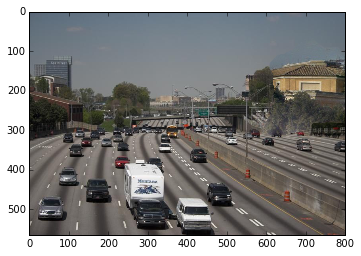

In [44]:
def local_context_match_im_output(orig_name, mask_name, match_name, local_context_size=55, 
                                  method='seamlessclone', dilation=True, save=False):
    """
    Sample usage:
    
    #output = local_context_match("source.jpg", "source_mask.jpg", "match.jpg", 60)
    #implot(output)    
    
    should be wrapped as a class or a dict, right now this is poor design.
    """
    orig, mask, match = read_images(orig_name, mask_name, match_name)
    orig_scene, mask_scene, orig_scene_no_mask, dialation_mask = get_masked_scene(orig, mask, local_context_size, dilation=dilation)
    best_x, best_y, match_scene = find_scene(orig_scene, match)
    mask_seam = create_seam_cut(orig_scene, mask_scene, match_scene, orig_scene_no_mask)
    
    # changing method arg won't change this.
    com_scene = composite_scene(orig_scene_no_mask, mask_seam, match_scene, dialation_mask, orig_scene, method="seamlessclone") 
    paste_com = composite_scene(orig_scene_no_mask, mask_seam, match_scene, dialation_mask, orig_scene, method="paste")
    paste_com1 = composite_scene(orig_scene_no_mask, 255-np2to3(mask_scene), match_scene, dialation_mask, orig_scene, method="paste")
    paste_com2 = composite_scene(orig_scene_no_mask, 255-np2to3(mask_scene), match_scene, dialation_mask, orig_scene, method="seamlessclone")
    paste_com3 = composite_scene(orig_scene_no_mask, mask_seam, paste_com2, dialation_mask, orig_scene, method="paste")
    paste_com3 = paste_com3.astype(np.uint8)
    paste_com4 = composite_scene(orig_scene_no_mask, 255-np2to3(mask_scene), paste_com3, dialation_mask, orig_scene, method="seamlessclone")
    output = composite(orig, paste_com3, mask, local_context_size)
    
    if save:
    #output lots of stuff
        cv2.imwrite("sample/%s.jpg" % ("orig_scene"), orig_scene)
        cv2.imwrite("sample/%s.jpg" % ("mask_scene"), mask_scene)
        cv2.imwrite("sample/%s.jpg" % ("orig_scene_no_mask"), orig_scene_no_mask)
        cv2.imwrite("sample/%s.jpg" % ("dialation_mask"), dialation_mask)
        cv2.imwrite("sample/%s.jpg" % ("match_scene"), match_scene)
        cv2.imwrite("sample/%s.jpg" % ("mask_seam"), mask_seam)
        cv2.imwrite("sample/%s.jpg" % ("com_scene"), com_scene)
        cv2.imwrite("sample/%s.jpg" % ("paste_com"), paste_com)
        cv2.imwrite("sample/%s.jpg" % ("paste_com1"), paste_com1)
        cv2.imwrite("sample/%s.jpg" % ("paste_com2"), paste_com2)
        cv2.imwrite("sample/%s.jpg" % ("paste_com3"), paste_com3)
        cv2.imwrite("sample/%s.jpg" % ("paste_com4"), paste_com4)


        cv2.imwrite("sample/%s.jpg" % ("output"), output)
    
    #return composite_scene(orig_scene_no_mask, 255-np2to3(mask_scene), match_scene, dialation_mask, orig_scene, method="seamlessclone")
    return output
    

    
output = local_context_match_im_output("source.jpg", "mask.jpg", "match.jpg",
                            local_context_size=45, save=True)
#output = local_context_match_im_output("images/input2.jpg", "images/input2_mask.jpg", "images/input2/result_img002.jpg",
#                             local_context_size=55, save=True)
implot(output)

In [45]:
# breakdown by part for another one.
#output = local_context_match_im_output("images/input2.jpg", "images/input2_mask.jpg", "images/input2/result_img002.jpg",
#                             local_context_size=55, save=True)

orig_name, mask_name, match_name = "source.jpg", "mask.jpg", "match.jpg"
local_context_size = 55
dilation = True

orig, mask, match = read_images(orig_name, mask_name, match_name)


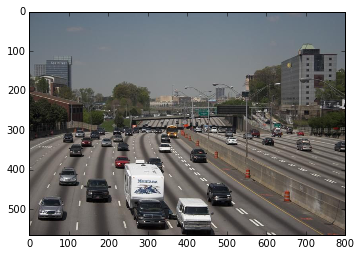

In [46]:
implot(orig)

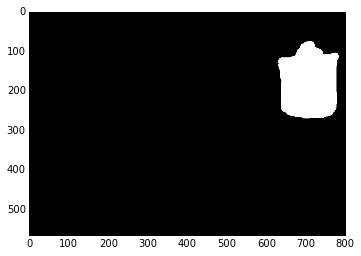

In [47]:
implot(255-np2to3(mask))

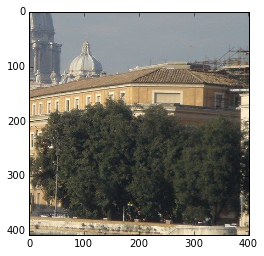

In [48]:
implot(match)

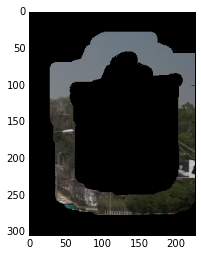

In [49]:
orig_scene, mask_scene, orig_scene_no_mask, dialation_mask = get_masked_scene(orig, mask, local_context_size, dilation=dilation)
implot(orig_scene)

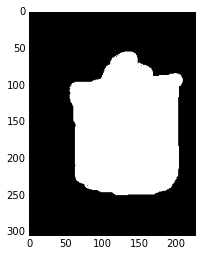

In [50]:
implot(255-np2to3(mask_scene))

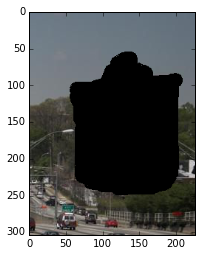

In [51]:
implot(orig_scene_no_mask)

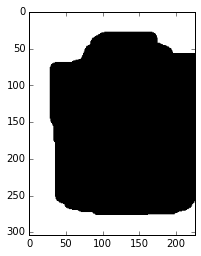

In [52]:
implot(255-np2to3(dialation_mask))

In [53]:
best_x, best_y, match_scene = find_scene(orig_scene, match)



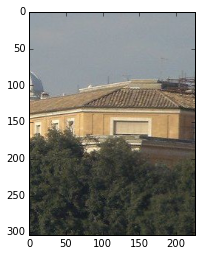

In [54]:
implot(match_scene)

In [55]:
mask_seam = create_seam_cut(orig_scene, mask_scene, match_scene, orig_scene_no_mask)

C:\Users\Chapm\Anaconda-2.3\lib\site-packages\IPython\kernel\__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\Chapm\Anaconda-2.3\lib\site-packages\IPython\kernel\__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


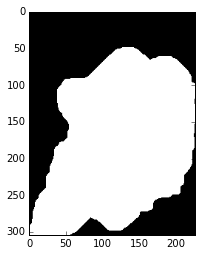

In [56]:
implot(mask_seam)

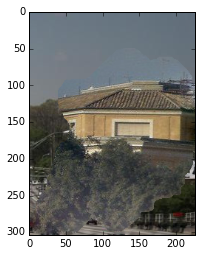

In [57]:
com_scene = composite_scene(orig_scene_no_mask, mask_seam, match_scene, dialation_mask, orig_scene, method="seamlessclone") 
paste_com = composite_scene(orig_scene_no_mask, mask_seam, match_scene, dialation_mask, orig_scene, method="paste")
paste_com1 = composite_scene(orig_scene_no_mask, 255-np2to3(mask_scene), match_scene, dialation_mask, orig_scene, method="paste")
paste_com2 = composite_scene(orig_scene_no_mask, 255-np2to3(mask_scene), match_scene, dialation_mask, orig_scene, method="seamlessclone")
paste_com3 = composite_scene(orig_scene_no_mask, mask_seam, paste_com2, dialation_mask, orig_scene, method="paste")
paste_com3 = paste_com3.astype(np.uint8)
paste_com4 = composite_scene(orig_scene_no_mask, 255-np2to3(mask_scene), paste_com3, dialation_mask, orig_scene, method="seamlessclone")
implot(paste_com4)

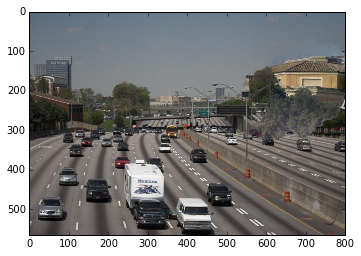

In [58]:
output = composite(orig, paste_com3, mask, local_context_size)
implot(output)